In [1]:
import nvjpeg
import numpy as np
from time import time
import os
from typing import *
import pathlib
from matplotlib import cm as matplotlib_color_map

from bokeh.layouts import column
from bokeh.models import Slider
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from bokeh.models.mappers import LogColorMapper
from nvjpeg import NvJpeg
import cv2
from matplotlib import pyplot as plt


output_notebook()

Loading BokehJS ...

In [2]:
def prepare_shape(mytuple: Tuple) -> Tuple:
    """ This promotes the elements inside a shape into np.uint64. It is intended to prevent overflows
        with some numpy operations that are sensitive to it, e.g. np.memmap """
    if not isinstance(mytuple, tuple):
        raise Exception("Internal error: prepare_shape() passed a non-tuple")
    return tuple(map(lambda x: np.uint64(x), mytuple))


def load_memmap(filename: str, mode: str = 'r') -> Tuple[Any, Tuple, int]:
    """ Load a memory mapped file created by the function save_memmap

    Args:
        filename: str
            path of the file to be loaded
        mode: str
            One of 'r', 'r+', 'w+'. How to interact with files

    Returns:
        Yr:
            memory mapped variable

        dims: tuple
            frame dimensions

        T: int
            number of frames


    Raises:
        ValueError "Unknown file extension"

    """
    if pathlib.Path(filename).suffix != '.mmap':
        logging.error(f"Unknown extension for file {filename}")
        raise ValueError(f'Unknown file extension for file {filename} (should be .mmap)')
    # Strip path components and use CAIMAN_DATA/example_movies
    # TODO: Eventually get the code to save these in a different dir
    fn_without_path = os.path.split(filename)[-1]
    fpart = fn_without_path.split('_')[1:-1]  # The filename encodes the structure of the map
    d1, d2, d3, T, order = int(fpart[-9]), int(fpart[-7]), int(fpart[-5]), int(fpart[-1]), fpart[-3]

    Yr = np.memmap(filename, mode=mode, shape=prepare_shape((d1 * d2 * d3, T)), dtype=np.float32, order=order)
    if d3 == 1:
        return (Yr, (d1, d2), T)
    else:
        return (Yr, (d1, d2, d3), T)

In [3]:
qual_cmaps = ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1',
              'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c']


def auto_colormap(
        n_colors: int,
        cmap: str = 'hsv',
        output: str = 'mpl',
        spacing: str = 'uniform',
        alpha: float = 1.0
    ) \
        -> List[Union[np.ndarray, str]]:
    """
    If non-qualitative map: returns list of colors evenly spread through the chosen colormap.
    If qualitative map: returns subsequent colors from the chosen colormap
    :param n_colors: Numbers of colors to return
    :param cmap:     name of colormap
    :param output:   option: 'mpl' returns RGBA values between 0-1 which matplotlib likes,
                     option: 'pyqt' returns QtGui.QColor instances that correspond to the RGBA values
                     option: 'bokeh' returns hex strings that correspond to the RGBA values which bokeh likes
    :param spacing:  option: 'uniform' returns evenly spaced colors across the entire cmap range
                     option: 'subsequent' returns subsequent colors from the cmap
    :param alpha:    alpha level, 0.0 - 1.0
    :return:         List of colors as either ``QColor``, ``numpy.ndarray``, or hex ``str`` with length ``n_colors``
    """

    valid = ['mpl', 'pyqt', 'bokeh']
    if output not in valid:
        raise ValueError(f'output must be one {valid}')

    valid = ['uniform', 'subsequent']
    if spacing not in valid:
        raise ValueError(f'spacing must be one of either {valid}')

    if alpha < 0.0 or alpha > 1.0:
        raise ValueError('alpha must be within 0.0 and 1.0')

    cm = matplotlib_color_map.get_cmap(cmap)
    cm._init()

    if output == 'pyqt':
        lut = (cm._lut * 255).view(np.ndarray)
    else:
        lut = (cm._lut).view(np.ndarray)

    lut[:, 3] *= alpha

    if spacing == 'uniform':
        if not cmap in qual_cmaps:
            cm_ixs = np.linspace(0, 210, n_colors, dtype=int)
        else:
            if n_colors > len(lut):
                raise ValueError('Too many colors requested for the chosen cmap')
            cm_ixs = np.arange(0, len(lut), dtype=int)
    else:
        cm_ixs = range(n_colors)

    colors = []
    for ix in range(n_colors):
        c = lut[cm_ixs[ix]]

        if output == 'bokeh':
            c = tuple(c[:3] * 255)
            hc = '#%02x%02x%02x' % tuple(map(int, c))
            colors.append(hc)

        else:  # mpl
            colors.append(c)

    return colors


In [4]:
lut = np.zeros(shape=((9000), 1, 3), dtype=np.uint8)

cmap = np.vstack(auto_colormap(n_colors=(9000), cmap='gnuplot2'))

lut[:, 0, :] = cmap[:, :-1] * 255

In [5]:
video_path = '/home/kushal/meso-data/020ee829-b1ea-4a25-bb2f-ba9625cb8915-m1_els__d1_512_d2_512_d3_1_order_F_frames_11200_.mmap'
Yr, dims, T = load_memmap(video_path)
images = np.reshape(Yr.T, [T] + list(dims), order='F')

In [6]:
nj = NvJpeg()
def to_jpeg(img, quality=50):
    img = img - 2000
    j0 = nj.encode(lut[img.astype(int)][:, :, 0, :], quality)
    # return nj.decode(j0)
    return cv2.cvtColor(nj.decode(j0), cv2.COLOR_BGR2BGRA)

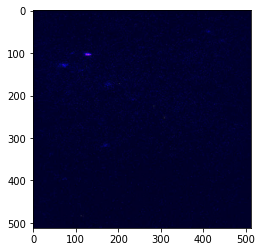

In [7]:
plt.imshow(to_jpeg(images[0]))

In [8]:
def bkapp(doc):   
    p = figure(plot_height=512, plot_width=512)#, output_backend='webgl')
    p.grid.grid_line_width = 0
    
    img0 = to_jpeg(images[0])
    img0 = img0.view(dtype=np.uint32).reshape((512, 512))

    g = p.image_rgba([img0], x=0, y=0, dw=10, dh=10, level="image")
    # g.glyph.color_mapper = color_mapper
    def update(attr, old, val):
        frame = to_jpeg(images[val])
        frame = frame.view(dtype=np.uint32).reshape((512, 512))
        g.data_source.data['image'] = [frame]
    
    s = Slider(start=0, end=11000, value=1, step=10, title="Frame index:")
    s.on_change('value', update)
    # doc.add_root(p)
    doc.add_root(column(p, s))

In [10]:
show(bkapp, notebook_url="http://localhost:8866")